C:\Users\IvanSukhanov\AppData\Local\Temp\ipykernel_22364\1454562600.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train_data = train_data.asfreq('H')
C:\Users\IvanSukhanov\AppData\Local\Temp\ipykernel_22364\1454562600.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_data = test_data.asfreq('H')
C:\Users\IvanSukhanov\AppData\Local\Temp\ipykernel_22364\1454562600.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original obj

Train MAE: 0.1891, Train R2: 0.9064
Test MAE: 0.3504, Test R2: 0.2262


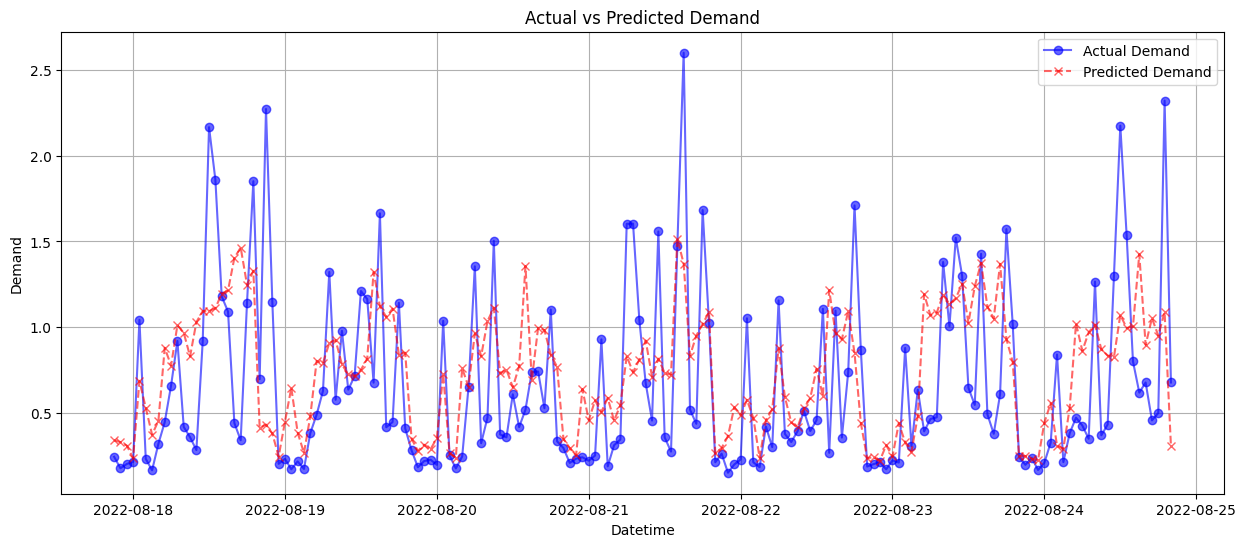

Feature Importance:
                Feature  Importance
2                 price    0.256883
1                  dwpt    0.174813
0                  temp    0.147468
7  heating_degree_hours    0.127864
4              hour_cos    0.099987
3              hour_sin    0.075183
5       day_of_week_sin    0.064430
6       day_of_week_cos    0.042491
8  cooling_degree_hours    0.010880


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# File paths
train_file_path = r"C:\Users\IvanSukhanov\Desktop\PhD\Classes\Energy\HW2\train.csv"
test_file_path = r"C:\Users\IvanSukhanov\Desktop\PhD\Classes\Energy\HW2\test.csv"

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Reformat datetime column
datetime_column = 'datetime'
if datetime_column not in train_data.columns:
    datetime_column_train = train_data.columns[0]  # Assuming the first column is the datetime column
    train_data.rename(columns={datetime_column_train: 'datetime'}, inplace=True)

if datetime_column not in test_data.columns:
    datetime_column_test = test_data.columns[0]
    test_data.rename(columns={datetime_column_test: 'datetime'}, inplace=True)

# Convert 'datetime'
train_data['datetime'] = pd.to_datetime(train_data['datetime'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
test_data['datetime'] = pd.to_datetime(test_data['datetime'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)

# Remove invalid datetime conversion
train_data.dropna(subset=['datetime'], inplace=True)
test_data.dropna(subset=['datetime'], inplace=True)

# Remove time zone
train_data['datetime'] = train_data['datetime'].dt.tz_localize(None)
test_data['datetime'] = test_data['datetime'].dt.tz_localize(None)

# datetime as index
train_data.set_index('datetime', inplace=True)
test_data.set_index('datetime', inplace=True)

# frequency information
train_data = train_data.asfreq('H')
test_data = test_data.asfreq('H')

# missing values
train_data['snow'].fillna(0, inplace=True)
train_data['demand'].fillna(train_data['demand'].median(), inplace=True)

test_data['snow'].fillna(0, inplace=True)
test_data['demand'].fillna(test_data['demand'].median(), inplace=True)

# Feature Engineering
def create_features(data):
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    data['heating_degree_hours'] = data['temp'].apply(lambda x: max(0, 15 - x))
    data['cooling_degree_hours'] = data['temp'].apply(lambda x: max(0, x - 15))
    return data

train_data = create_features(train_data)
test_data = create_features(test_data)

# Cyclical encoding
def cyclical_encoding(data):
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    return data

train_data = cyclical_encoding(train_data)
test_data = cyclical_encoding(test_data)

# features and target
features = ['temp', 'dwpt', 'price', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'heating_degree_hours', 'cooling_degree_hours']
target = 'demand'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Standardization features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RFR
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions
train_predictions = rf_model.predict(X_train_scaled)
test_predictions = rf_model.predict(X_test_scaled)

# MAE and R2 scores
mae_train = mean_absolute_error(y_train, train_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)
r2_train = r2_score(y_train, train_predictions)
r2_test = r2_score(y_test, test_predictions)
print(f"Train MAE: {mae_train:.4f}, Train R2: {r2_train:.4f}")
print(f"Test MAE: {mae_test:.4f}, Test R2: {r2_test:.4f}")

# actual vs predicted demand for the test set
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Demand', color='blue', linestyle='-', marker='o', alpha=0.6)
plt.plot(y_test.index, test_predictions, label='Predicted Demand', color='red', linestyle='--', marker='x', alpha=0.6)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.grid(True)
plt.show()

# feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importances)
